In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util
from bmi_dynamics_code import analyze_lqr

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [4]:
%matplotlib notebook

In [5]:
a_list = ['grom', 'jeev']
a2num_days = {'grom':9, 'jeev':4}

In [139]:
#Loop animals, dates
#Load all session's results
save_home = r'D:\DATA\bmi_co_obs_backup'
# load_file = 'lqr_sim_20trials_decoder_null_dyn.pkl'
load_file = 'lqr_sim_20trials.pkl'

r_pool = {}
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
#         print(os.path.exists(load_dir))
        load_path = os.path.join(load_dir, load_file)
        with open(load_path, 'rb') as f: 
            r = pickle.load(f)     
        r_pool[(a,d)] = r
#         del r_pool[(a,d)]['model_cm']
        

('grom', 0)
('grom', 1)
('grom', 2)
('grom', 3)
('grom', 4)
('grom', 5)
('grom', 6)
('grom', 7)
('grom', 8)
('jeev', 0)
('jeev', 1)
('jeev', 2)
('jeev', 3)


In [140]:
a = 'grom'
d = 0
target_list = r_pool[a,d]['target_list']
task_rot_list = r_pool[a,d]['task_rot_list']

In [141]:
def pool_u_norm_over_models(df, model_list, target_list, task_rot_list):
    r_u = {}
    for m in model_list:
        r_u[m]=[]

    for target in target_list:
        for task in task_rot_list:
            for i,m in enumerate(model_list):
                sel = \
                (df['target']==target)\
                &(df['task']==task)\
                &(df['model']==m)
                y_i = float(df.loc[sel,'norm_u'])
                
                r_u[m].append(y_i)                  

    return r_u

In [142]:
model_list = ['n_do', 'n_o', 'n_d', 'n_null']
df2analyze = 'norm_u_df_nl'
u_ad = {}
for a in a_list: 
    for d in range(a2num_days[a]):
        u_df = r_pool[a, d][df2analyze]
        
        u_ad[a,d] = pool_u_norm_over_models(u_df, model_list, target_list, task_rot_list)


In [143]:
r_pool['grom', 2].keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [144]:
r_pool['grom', 2]['A_dic'].keys()

['n_null', 'n_d', 'n_do', 'n_o']

In [131]:
# dynamics_dir = r'D:\Dropbox\BMI_co_obs_paper\data'
# dynamics_path = os.path.join(dynamics_dir, 'dynamics_for_v.pkl')
# with open(dynamics_path, 'rb') as f: 
#     dynamics_dic = pickle.load(f)

In [137]:
# del dynamics_dic

In [132]:
# dynamics_dic.keys()

[('grom', 8, 'b'),
 ('jeev', 2, 'b'),
 ('jeev', 1, 'b'),
 ('grom', 4, 'b'),
 ('grom', 5, 'b'),
 ('grom', 2, 'b'),
 ('grom', 5, 'A'),
 ('grom', 2, 'A'),
 ('grom', 1, 'A'),
 ('jeev', 3, 'A'),
 ('grom', 1, 'b'),
 ('grom', 7, 'b'),
 ('jeev', 0, 'b'),
 ('grom', 0, 'b'),
 ('grom', 0, 'A'),
 ('jeev', 0, 'A'),
 ('grom', 6, 'b'),
 ('grom', 8, 'A'),
 ('jeev', 3, 'b'),
 ('grom', 7, 'A'),
 ('grom', 3, 'A'),
 ('jeev', 1, 'A'),
 ('grom', 6, 'A'),
 ('grom', 3, 'b'),
 ('jeev', 2, 'A'),
 ('grom', 4, 'A')]

<IPython.core.display.Javascript object>


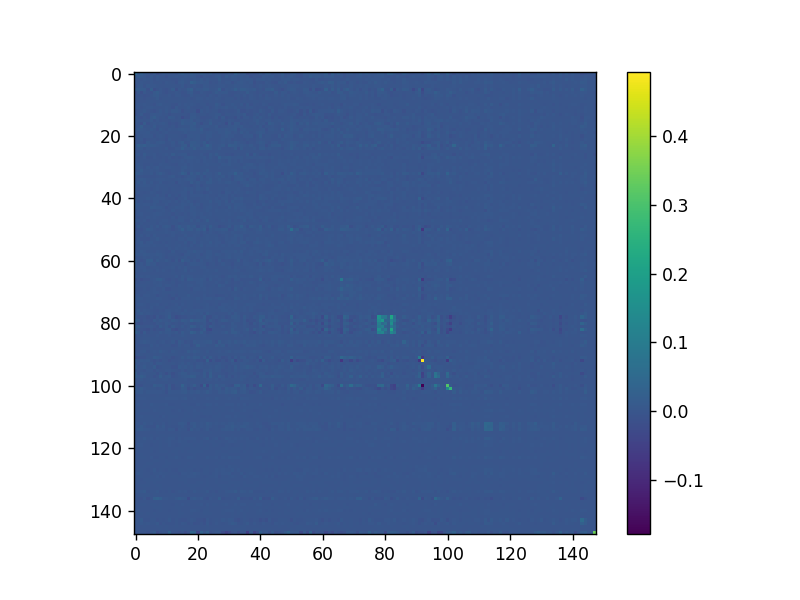

<IPython.core.display.Javascript object>


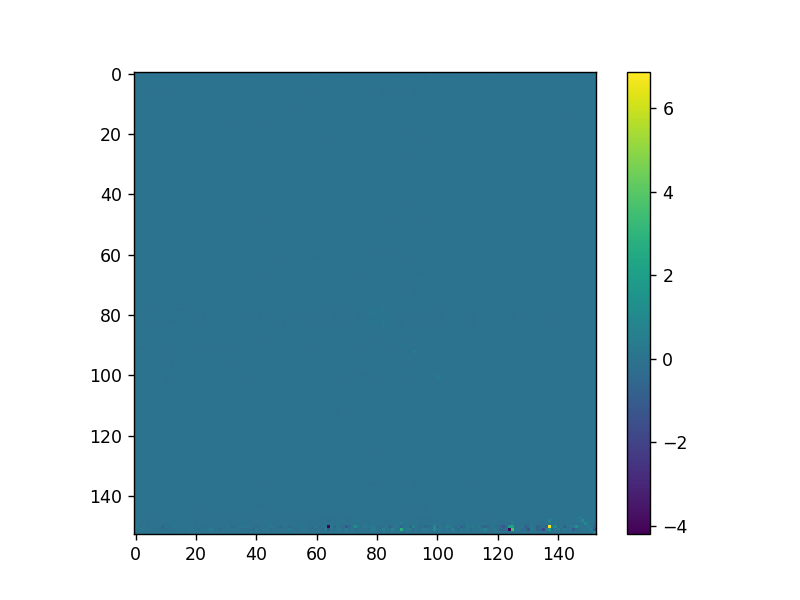

In [133]:
# test = r_pool['grom', 8]['A_dic']['n_d']

a = 'grom'
d = 2

test = dynamics_dic[a,d,'A']
plt.figure()
plt.imshow(test)
plt.colorbar()

test = r_pool[a, d]['A_dic']['n_d']
plt.figure()
plt.imshow(test)
plt.colorbar()

In [109]:
r_pool[a, d].keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

<IPython.core.display.Javascript object>


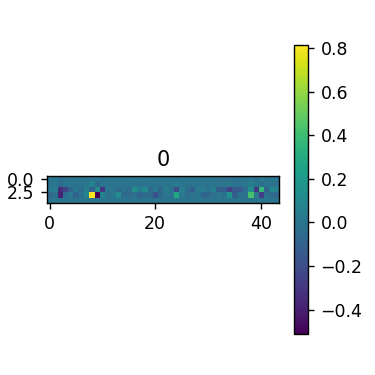

<IPython.core.display.Javascript object>


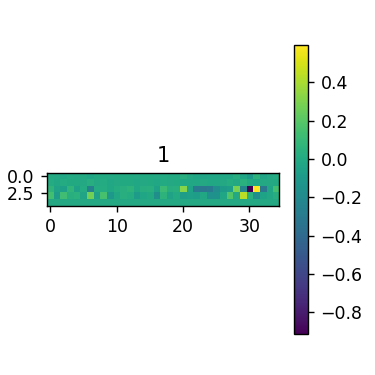

<IPython.core.display.Javascript object>


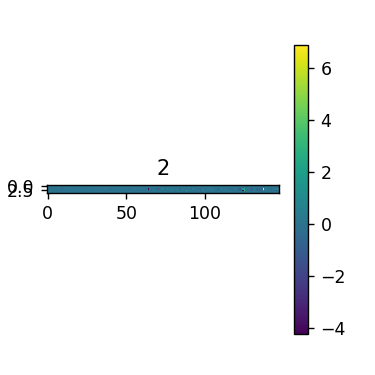

<IPython.core.display.Javascript object>


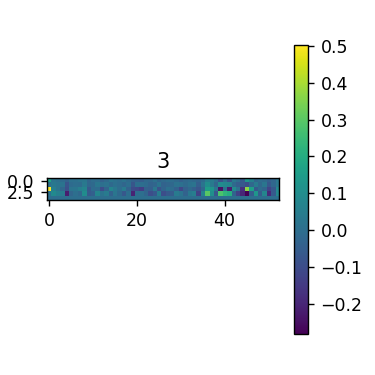

<IPython.core.display.Javascript object>


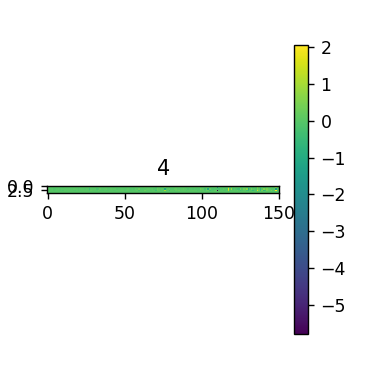

<IPython.core.display.Javascript object>


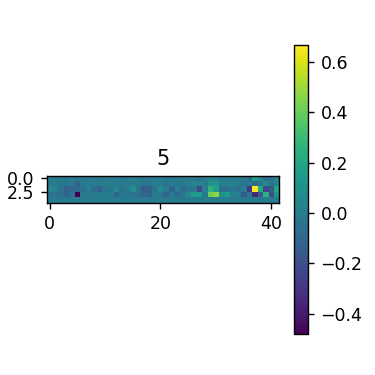

<IPython.core.display.Javascript object>


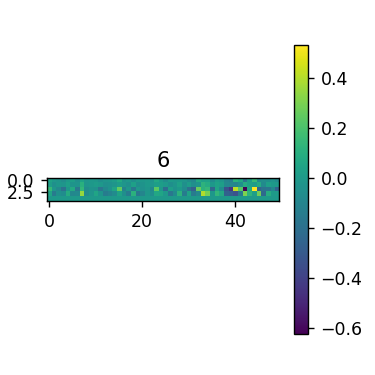

<IPython.core.display.Javascript object>


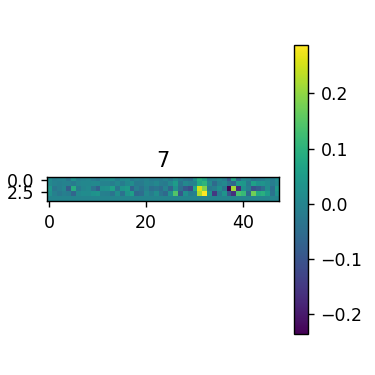

<IPython.core.display.Javascript object>


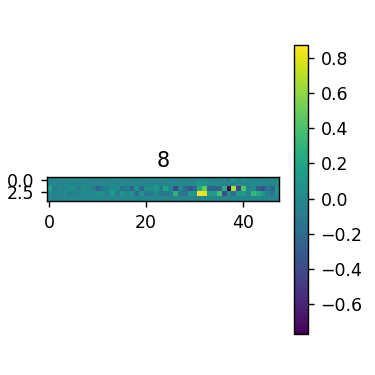

In [114]:
# test = r_pool['grom', 8]['A_dic']['n_d']

a = 'grom'
for d in range(a2num_days[a]):
    test = r_pool[a, d]['Kn']
    plt.figure(figsize=(3,3))
    plt.imshow(test)
    plt.colorbar()
    plt.title(d)

<IPython.core.display.Javascript object>


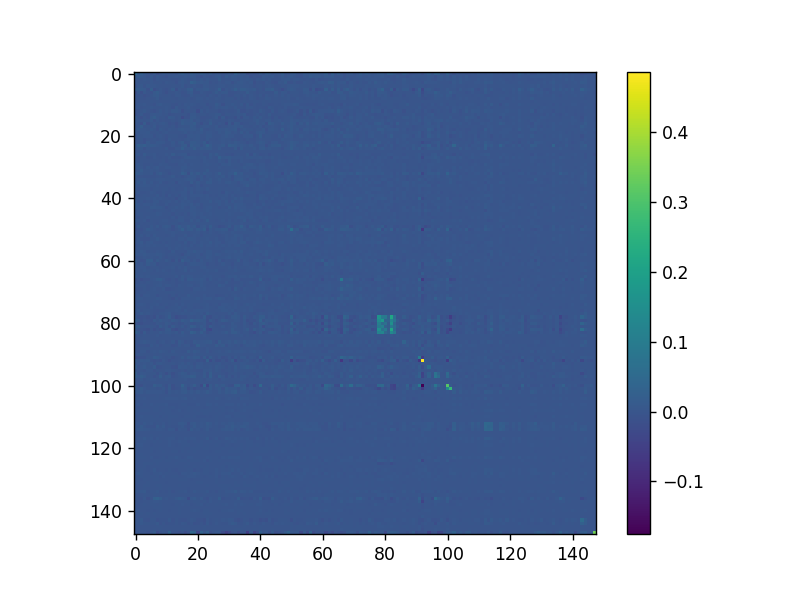

<IPython.core.display.Javascript object>


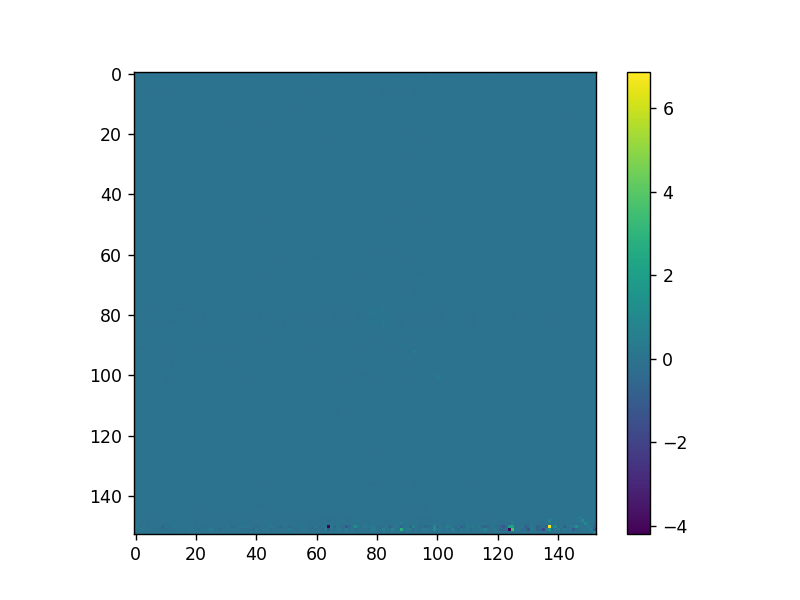

In [138]:
# test = r_pool['grom', 8]['A_dic']['n_d']

a = 'grom'
d = 2

test = r_pool[a, d]['An_m'] #dynamics_dic[a,d,'A']
plt.figure()
plt.imshow(test)
plt.colorbar()

test = r_pool[a, d]['A_dic']['n_d']
plt.figure()
plt.imshow(test)
plt.colorbar()

In [150]:
a = 'grom'
d = 2
x = u_ad[a,d]['n_d']
y = u_ad[a,d]['n_null']

print(np.mean(x))
print(np.mean(y))

3.86493389856926
3.60228347264227


In [41]:
a = 'grom'
d = 2
x = u_ad[a,d]['n_do']
y = u_ad[a,d]['n_o']

print(np.mean(x))
print(np.mean(y))

4.537073500462198
4.255881686541054


In [44]:
a = 'grom'
d = 2
x = u_ad[a,d]['n_do']
y = u_ad[a,d]['n_o']

print(np.mean(x))
print(np.mean(y))

4.513869726122285
4.245891144887742


In [9]:
r_pool['grom', 0]['norm_u_df_nl']

,norm_u,target,task,model
0,4.552001,0,0.0,n_do
1,8.202651,0,0.0,n_null
2,6.686493,0,0.0,n_o
3,4.686646,0,0.0,n_d
4,8.903628,0,1.1,n_do
5,13.557184,0,1.1,n_null
6,12.692254,0,1.1,n_o
7,8.771609,0,1.1,n_d
8,8.982160,0,1.2,n_do
9,13.799674,0,1.2,n_null
